In steel plants, unexpected equipment failure leads to:

Production loss

Safety hazards

High repair costs

This problem is framed as a rare-event binary classification task, similar in structure to credit risk and fraud detection, where the goal is not just prediction accuracy, but reliable, calibrated probabilities for decision-making.

A Business Objective i always kept in mind

Not,

Max accuracy

But

Minimize downtime

Avoid unnecessary stops

Protect expensive machines

Thats what i need.

My probabilities are calibrated and decision-ready ✅

🏌️‍♂️ MY DATASET

AI4I 2020 Predictive Maintenance Dataset

Industrial sensor telemetry

Rare machine failures

https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020

Importing necessary packages and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score,
    precision_recall_curve,
    auc,
    log_loss,
    brier_score_loss
)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

My thoughts

This mirrors credit risk toolkits:

MCC → imbalance robustness

Brier → probability quality mse of predict proba and actual label lower is better and 0 will be perfect calibration

Calibration → overconfidence control

Accuracy is intentionally not emphasized.

In [5]:
from xgboost import XGBClassifier

In [6]:
from google.colab import files

uploaded = files.upload()

Saving ai4i2020.csv to ai4i2020.csv


In [7]:
df = pd.read_csv("ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [8]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())


#14 columns 10k rows

Shape: (10000, 14)

Missing values:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [9]:
X = df.drop(columns=["UDI"]) # redundant column udi is just identifier

For intuition  Predictive maintenance = rare events

[0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Total samples = 10

Failures (1s) = 2


mean = (2) / (10) = 0.2

Accuracy in such case will be completely redundant Its kind of cheating with imbalance


PLets say model predicts everything as 0 (no failure)
Confusion Matrix
True Negatives = 8

False Negatives = 2

True Positives = 0

False Positives = 0     Accuracy will be 80 percent so model will be worthless

Failure rate: 3.39%


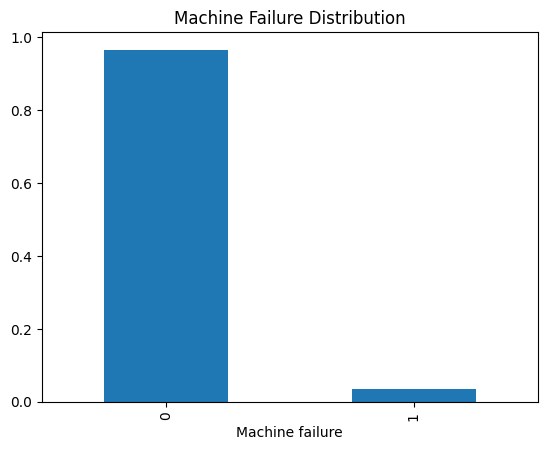

In [10]:
target = "Machine failure"
failure_rate = df[target].mean()

print(f"Failure rate: {failure_rate*100:.2f}%")

df[target].value_counts(normalize=True).plot(
    kind="bar",
    title="Machine Failure Distribution"
)
plt.show()


Failure is rare but costly missing one is worse than just a false alarm  ,As per above chart there is humongous class imbalance only in real life Only 3.39 percent machines have failed with the sensory data available above

In [11]:
features = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

target = "Machine failure"

In [12]:
# Numerical summary of features by failure status
susnata_eda_summary = df.groupby(target)[features].agg(
    ["mean", "median", "std", "min", "max"]
)



In [13]:
susnata_eda_summary

Air temperature [K]                                 \
                               mean median       std    min    max   
Machine failure                                                      
0                        299.973999  300.0  1.990748  295.3  304.5   
1                        300.886431  301.6  2.071473  295.6  304.4   

                Process temperature [K]                                 ...  \
                                   mean median       std    min    max  ...   
Machine failure                                                         ...   
0                            309.995570  310.0  1.486846  305.7  313.8  ...   
1                            310.290265  310.4  1.363686  306.1  313.7  ...   

                Torque [Nm]                               Tool wear [min]  \
                       mean median        std   min   max            mean   
Machine failure                                                             
0                 39.629655   39.9   9.472080  12.6  70.0      106.693717   
1                 50.168142   53.7  16.374498   3.8  76.6      143.781711   

                                            
                median        std min  max  
Machine failure                             
0                107.0  62.945790   0  246  
1                165.0  72.759876   0  253  

[2 rows x 25 columns]

Susnata Key takeaways

1️⃣  Air Temperature [K] 🌡️

Observation

Mean & median are almost the same for failures and non-failures

Std is also very similar

My Interpretation

Ambient air temp is stable

It does NOT discriminate failure well

Industry translation

# The environment is fine. The machine is dying due to internal stress, not weather
📉 Feature importance: Low

2️⃣  Process Temperature [K] 🔥

Observation

Failed machines have:

Slightly higher mean & median

Similar range but tighter clustering near higher values

Interpretation

Process temperature creeping up = internal friction / inefficiency

Small shift matters in industrial systems

Industry translation

“The machine is overheating from inside, not outside.”

📈 Feature importance: Medium

 3️⃣ Torque [Nm] ⚙️ (THIS IS VERY CRITICAL)

Observation

Mean torque jumps significantly for failures

Median also jumps (not just outliers!)

Std is much higher for failures

Interpretation

Machines that fail:

Require more force to do the same job

Show unstable load behavior

This is classic mechanical degradation.

Industry translation

“The machine is struggling. Bearings worn, friction rising, resistance increasing.”

📈📈 Feature importance: VERY HIGH

My Verdict: Torque is screaming before failure 🚨

4️⃣ Tool Wear [min] 🧱 (Silent killer)

Observation

Failed machines have:

Much higher mean & median

Large spread, high max values

Interpretation

Tool wear accumulates over time

Once past a threshold → cascading failure

Industry translation

“We ignored maintenance… now the bill is paid in downtime. This is loss making for us”

📈📈 Feature importance: CRITICAL

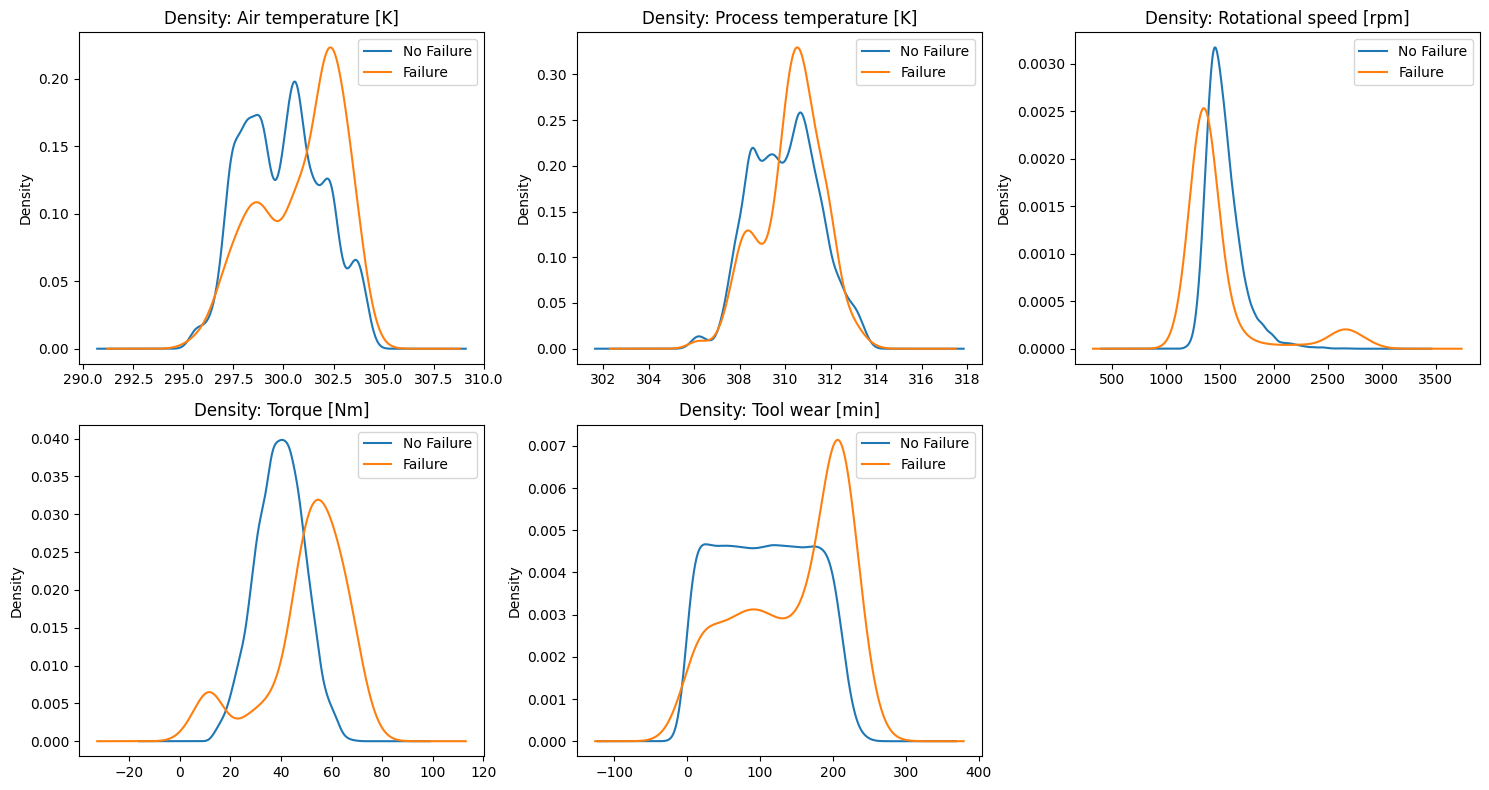

In [14]:
import math

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    df[df[target] == 0][col].plot(
        kind="kde",
        ax=axes[i],
        label="No Failure"
    )
    df[df[target] == 1][col].plot(
        kind="kde",
        ax=axes[i],
        label="Failure"
    )
    axes[i].set_title(f"Density: {col}")
    axes[i].legend()

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**My Failure vs No Faliure Analysis**

Each plot compares:

Blue = No Failure

Orange = Failure

If curves:

Overlap heavily → weak signal

Shift right / separate / wider spread → strong failure signal

This is distribution-level EDA, is much stronger than just mean/std.

1️⃣ Air Temperature [K] 🌬️

What I am seeing

Heavy overlap between failure & non-failure

Failure curve slightly right-shifted, but marginal

Meaning

Ambient conditions are almost the same

Air temperature alone won’t predict failure

My Business translation

“Factory environment is stable. Failure isn’t caused by weather.”

2️⃣ Process Temperature [K] 🔥

What I see

Failure curve shifted slightly to the right

More mass at higher temperatures

Meaning

Machines that fail tend to operate at higher internal temps

Subtle but consistent signal

Engineering insight

Friction ↑

Cooling efficiency ↓

Energy loss ↑

📈 Predictive power: Medium

3️⃣ Rotational Speed [rpm] 🌀

What I see

Huge overlap

Almost same peak

Long tail but inconsistent

Meaning

RPM is controlled by operations

Speed itself isn’t killing the machine

Key insight

Speed doesn’t fail machines — load under speed does.

📉 Predictive power: Low–Medium

4️⃣ Torque [Nm] ⚙️🔥 (My STAR FEATURE)

What I see

Clear right shift for failures

Much wider spread

Less overlap than previous plots

Meaning

Failed machines require more torque

Indicates:

Wear

Misalignment

Bearing degradation

Mechanical truth

Same RPM + higher torque = machine is fighting resistance.

📈📈 Predictive power: VERY HIGH

This is a pre-failure scream, not noise 🚨

5️⃣ Tool Wear [min] 🧱💀 (THIS IS DEATH CLOCK)

What I see

Failure density concentrated at high wear

Non-failure peaks at lower wear

Clear separation

Meaning

Tool wear accumulates → crosses a threshold → failure

This is a leading indicator

Business truth

“Failure is not sudden. Maintenance was skipped.”

📈📈📈 Predictive power: CRITICAL

One key aspect of torque is that machine that failed were  operating at higher



torque than normal

Observations I implicitly discovered

Torque shifts right → stress accumulation

Tool wear clearly higher for failures

RPM distribution bends (interaction effect!)

Temperatures alone weak → but combine with others, they matter

⚠️ Important:
No single feature screams failure.
Failures happen due to interactions.

That’s why trees + boosting shine.

Here i have created an ingenious chart that shows failure by creating torque bins

/tmp/ipython-input-4046320771.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_by_torque = df.groupby("Torque_bin")[target].mean()


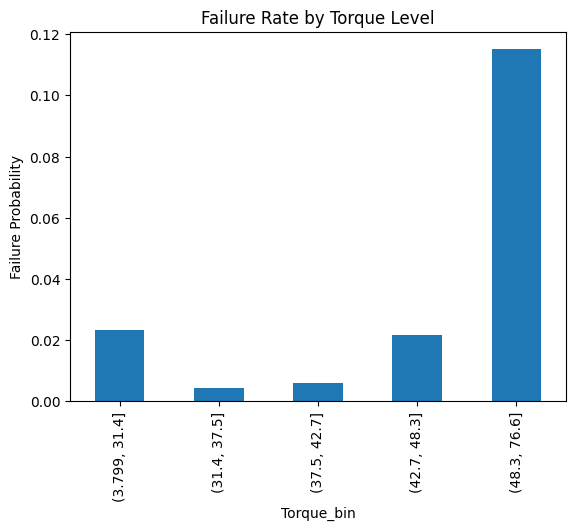

In [15]:
df["Torque_bin"] = pd.qcut(df["Torque [Nm]"], q=5)

failure_by_torque = df.groupby("Torque_bin")[target].mean()

failure_by_torque.plot(
    kind="bar",
    title="Failure Rate by Torque Level"
)
plt.ylabel("Failure Probability")
plt.show()

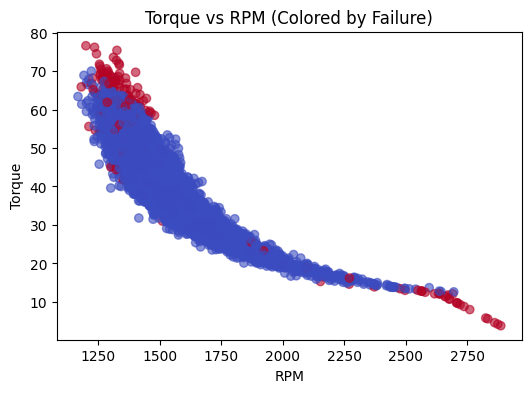

In [16]:
plt.figure(figsize=(6,4))
plt.scatter(
    df["Rotational speed [rpm]"],
    df["Torque [Nm]"],
    c=df[target],
    cmap="coolwarm",
    alpha=0.6
)
plt.xlabel("RPM")
plt.ylabel("Torque")
plt.title("Torque vs RPM (Colored by Failure)")
plt.show()

From above torque vs rpm  I visually discovered:

Failures cluster in high torque + lower RPM zones

That’s mechanical stress physics

My take away machine is failing not because torque is high or RPM is low but a combination

That single plot justifies:

Random Forest

XGBoost

Models that can handle non linear data

Interaction learning  

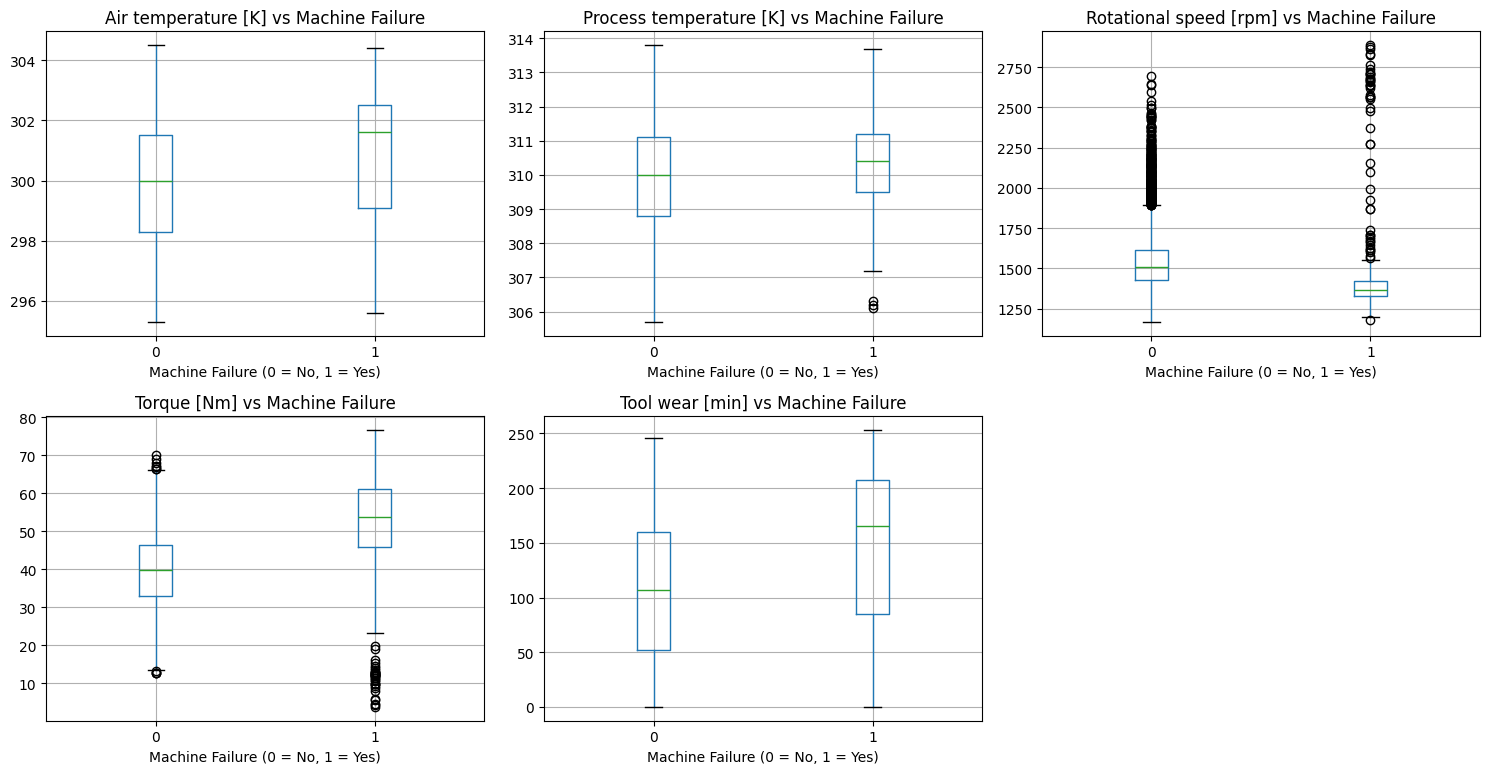

In [17]:
import math

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(features):
    df.boxplot(column=col, by=target, ax=axes[i])
    axes[i].set_title(f"{col} vs Machine Failure")
    axes[i].set_xlabel("Machine Failure (0 = No, 1 = Yes)")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("")
plt.tight_layout()
plt.show()


What I notice from above Box plots

No feature has a perfect separation

Failures happen due to combined stress, not one villain

MY Feature	Signal Strength	Insight



Air Temp	❄️ Weak	           kinda   Contextual

Process Temp	🌡️ Medium	      kind of   Thermal stress

Rotational Speed	⚙️ Strong	   Early slowdown

Torque	🔥 Very Strong	       Mechanical struggle

Tool Wear	💀 Strongest	      Lifecycle exhaustion


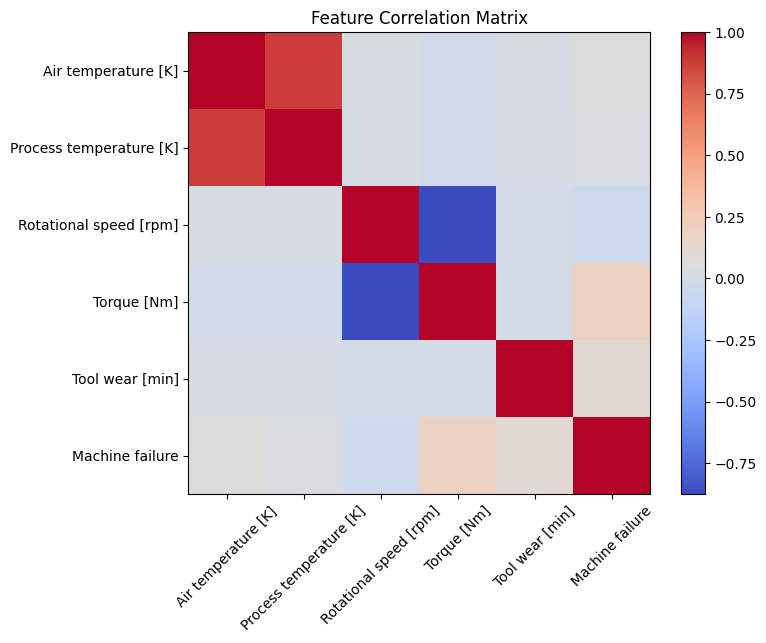

In [18]:
corr = df[features + [target]].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.show()

I did the above correlation heatmap Not to drop features, but to:

Understand redundancy

Validate physics (RPM ↔ Torque negative correlation)

Outlier treatment

Outliers in predictive maintenance are often the signal, not the noise.

If machines failed only in “normal” ranges, life would be easy**

I will only drop  when they are data errors, not reality.

Tree models (RF, XGBoost)	😎 Don’t care much
Logistic Regression	😬 Sensitive
KNN / Distance models	💀 Very sensitive
Neural Nets	😐 Scaling matters

In predictive maintenance and credit risk modeling, outliers often represent early warning signals rather than noise, so removing them can severely weaken a model’s ability to predict failures or defaults. Instead of dropping such observations, industry practice favors robust scaling, winsorization, or selective transformations like log transformation for right skewed  that preserve extreme behavior while preventing it from dominating model training. This ensures models remain sensitive to risk while maintaining numerical stability and business credibility.

In [19]:
df[df['Machine failure']==1].describe()  # udi is just identifier reduddant column wil drop it


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.0,339.000000,339.000000,339.000000,339.000000,339.000000
mean,4647.722714,300.886431,310.290265,1496.486726,50.168142,143.781711,1.0,0.135693,0.339233,0.280236,0.289086,0.002950
std,2380.540041,2.071473,1.363686,384.943547,16.374498,72.759876,0.0,0.342969,0.474149,0.449778,0.454008,0.054313
min,51.000000,295.600000,306.100000,1181.000000,3.800000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3555.000000,299.100000,309.500000,1326.500000,45.950000,84.500000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4442.000000,301.600000,310.400000,1365.000000,53.700000,165.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5971.000000,302.500000,311.200000,1421.500000,61.200000,207.500000,1.0,0.000000,1.000000,1.000000,1.000000,0.000000
max,9975.000000,304.400000,313.700000,2886.000000,76.600000,253.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df[df['Machine failure']==0].describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,9661.000000,9661.000000,9661.000000,9661.000000,9661.000000,9661.000000,9661.0,9661.0,9661.0,9661.0,9661.0,9661.000000
mean,5012.878791,299.973999,309.995570,1540.260014,39.629655,106.693717,0.0,0.0,0.0,0.0,0.0,0.001863
std,2902.384020,1.990748,1.486846,167.394734,9.472080,62.945790,0.0,0.0,0.0,0.0,0.0,0.043126
min,1.000000,295.300000,305.700000,1168.000000,12.600000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
25%,2479.000000,298.300000,308.800000,1429.000000,33.100000,52.000000,0.0,0.0,0.0,0.0,0.0,0.000000
50%,5068.000000,300.000000,310.000000,1507.000000,39.900000,107.000000,0.0,0.0,0.0,0.0,0.0,0.000000
75%,7532.000000,301.500000,311.100000,1615.000000,46.300000,160.000000,0.0,0.0,0.0,0.0,0.0,0.000000
max,10000.000000,304.500000,313.800000,2695.000000,70.000000,246.000000,0.0,0.0,0.0,0.0,0.0,1.000000


In [21]:
import numpy as np
from sklearn.preprocessing import RobustScaler
from scipy.stats.mstats import winsorize

# 1. Dropping non-predictive identifiers
df_model = df.drop(columns=["UDI"])

# 2. Separating my features & target
X = df_model.drop(columns=["Machine failure"])
y = df_model["Machine failure"]

# 3. Winsorizing only heavy-tailed risk features (keep signal, cap extremes)
X["Torque_win"] = winsorize(X["Torque [Nm]"], limits=[0.01, 0.01])
X["Tool_wear_win"] = winsorize(X["Tool wear [min]"], limits=[0.01, 0.01])

# 4. Selecting numeric columns for scaling (mainly for linear models)
num_cols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque_win",
    "Tool_wear_win"
]

# 5. Robust scaling (median & IQR based)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X[num_cols])

My rationale for doing above Instead of removing outliers, we applied winsorization and robust scaling to preserve rare failure signals while maintaining numerical stability, which is standard practice in predictive maintenance and credit risk modeling

Winsorize: cap at 1%–99%

RobustScaler: scale by median & IQR (25–75)

In [22]:

X = df[features]
y = df[target]

In [23]:
X.columns = (
    X.columns
    .str.replace("[", "", regex=False)
    .str.replace("]", "", regex=False)
    .str.replace("<", "", regex=False)
    .str.replace(">", "", regex=False)
    .str.replace(" ", "_")
)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# The Failures are rare.
#Stratification ensures risk distribution stability, exactly like credit risk modeling.

BASELINE LOGISTIC REGRESSION  beacuse its interpretable and probabilistic in nature Kind of a reference rulwer

Logistic regression needs scaled features.Big value can dominate
Tree models do not.

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
log_model = LogisticRegression(
    class_weight="balanced", # since my dataset is highly imbalanced penelize mistakes on faliures more than non failure as missing failure is worse than un
    #unnecessary intervention   # if  not my model can have bogus high accuracy saying no faliure everytime as 97 percent of dataset is no  failure
    max_iter=1000# number of iterations how many optimization step logistic regression takes to converge fin best Beta coeefiients to minimize loss
)

log_model.fit(X_train_scaled, y_train)

y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]
y_pred_log = log_model.predict(X_test_scaled)

In [27]:
print("LogReg MCC:", matthews_corrcoef(y_test, y_pred_log))
print("LogReg ROC-AUC:", roc_auc_score(y_test, y_prob_log))
print("LogReg Brier:", brier_score_loss(y_test, y_prob_log))

LogReg MCC: 0.29729768136067186
LogReg ROC-AUC: 0.907974059188893
LogReg Brier: 0.124341951179771


Failures are nonlinear → trees capture interactions.





In [28]:
rf_model = RandomForestClassifier(
    n_estimators=300, # number of trees
    max_depth=8, # depth of tress
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = rf_model.predict(X_test)

In [29]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int) # if a model has predict proba over 0.5 then considering it fail


In [30]:
for name, y_prob, y_pred in [
    ("RF", y_prob_rf, y_pred_rf),
    ("XGB", y_prob_xgb, y_pred_xgb)
]:
    print(name, "MCC:", matthews_corrcoef(y_test, y_pred))
    print(name, "ROC-AUC:", roc_auc_score(y_test, y_prob))
    print(name, "Brier:", brier_score_loss(y_test, y_prob))
    print("-"*30)

RF MCC: 0.5964483937000653
RF ROC-AUC: 0.974508281573499
RF Brier: 0.025354670345111758
------------------------------
XGB MCC: 0.6452487795479251
XGB ROC-AUC: 0.9726890756302522
XGB Brier: 0.023980709699489056
------------------------------


MY Core metrics
Metric
ROC-AUC	Can it rank risky machines higher?
MCC	Are decisions balanced under imbalance?
Brier	Are probabilities honest?
LogLoss	Penalizes confident wrong predictions

My  XGB is doing amazing

ROC-AUC ≈ 0.97

MCC ≈ 0.65

Brier ≈ 0.02

This is sublime mcc of 0.65 roc of 0.97 and least brier mse of predict proba and actual label

**START OF CALIBRATION **




When I MUST calibrate RF:

Rare-event problems (✔️ I  have)

Cost-sensitive decisions (✔️ Ihave)

Comparing probabilities across models (✔️ I again do have)

When I could have  skipped it

Pure ranking tasks only

No thresholding / no cost logic

I am doing risk decisioning, so calibration is correct.  Calibrating  RF (Platt scaling)

In [31]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    rf_model,
    method="sigmoid",   # Platt scaling
    cv=5
)

calibrated_rf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=8,
                                                        n_estimators=300,
                                                        random_state=42))

In [32]:
y_prob_rf_cal = calibrated_rf.predict_proba(X_test)[:, 1]
print("Calibrated RF ROC-AUC:", roc_auc_score(y_test, y_prob_rf_cal))
print("Calibrated RF Brier:", brier_score_loss(y_test, y_prob_rf_cal))
print("Calibrated RF LogLoss:", log_loss(y_test, y_prob_rf_cal))

Calibrated RF ROC-AUC: 0.9719659602971623
Calibrated RF Brier: 0.017231703575520375
Calibrated RF LogLoss: 0.06374951721462163


In [33]:
calibrated_xgb = CalibratedClassifierCV(
    xgb_model,
    method="sigmoid",
    cv=5
)

calibrated_xgb.fit(X_train, y_train)
y_prob_cal = calibrated_xgb.predict_proba(X_test)[:,1]

print("Calibrated ROC-AUC:", roc_auc_score(y_test, y_prob_cal))
print("Calibrated Brier:", brier_score_loss(y_test, y_prob_cal))
print("Calibrated LogLoss:", log_loss(y_test, y_prob_cal))

Calibrated ROC-AUC: 0.9732751796370722
Calibrated Brier: 0.013082434934228221
Calibrated LogLoss: 0.05378454576829456


In this section, calibrated probability outputs from Random Forest (y_prob_rf_cal) and XGBoost (y_prob_cal) are evaluated separately. All reported ROC-AUC, Brier, LogLoss, and calibration curves are computed using post-calibration (Platt-scaled) probabilities, ensuring comparability and reliable probability interpretation.

CALIBRATION CURVE (RF vs XGB)

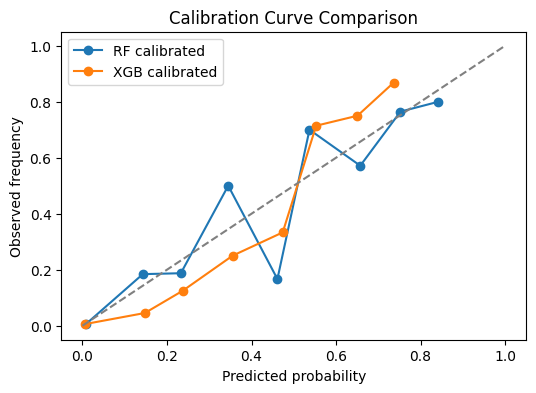

In [34]:
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_prob_rf_cal, n_bins=10)
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_prob_cal, n_bins=10)

plt.figure(figsize=(6,4))
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label="RF calibrated")
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label="XGB calibrated")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.show()

If the calibration curve lies below the diagonal, the model is overconfident; if it lies above, it is underconfident. Our calibrated XGBoost model stays close to the diagonal, indicating reliable probability estimates suitable for threshold-based decisions

Random Forest provided strong ranking but imperfect probability estimates. Since this was a cost-sensitive rare-event problem, I calibrated the Random Forest using Platt scaling to improve probability reliability without affecting ranking

**At higher probability regions (0.7–0.8), the system is already in the intervention zone. Therefore, even if XGBoost is slightly underconfident in that region, the operational decision remains unchanged and intervention still occurs.

However, in the mid-probability region (around 0.4–0.56), the Random Forest model shows overconfidence, meaning it predicts higher risk than what is observed in reality. This can lead to excessive false positives, resulting in unnecessary maintenance actions**

I am Computing  Expected Cost for Each Threshold

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define thresholds to test
thresholds = np.linspace(0, 1, 101)

# Business costs
cost_fp = 1000     # unnecessary maintenance
cost_fn = 10000    # missed failure

total_costs = []

for t in thresholds:
    # Apply threshold to probabilities
    y_pred_t = (y_prob_cal >= t).astype(int)

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

    # Expected business cost
    cost = fp * cost_fp + fn * cost_fn
    total_costs.append(cost)

# Find cost-optimal threshold
optimal_idx = np.argmin(total_costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = total_costs[optimal_idx]

print(f"Cost-optimal threshold: {optimal_threshold:.3f}")
print(f"Minimum expected cost: {min_cost}")

Cost-optimal threshold: 0.250
Minimum expected cost: 145000


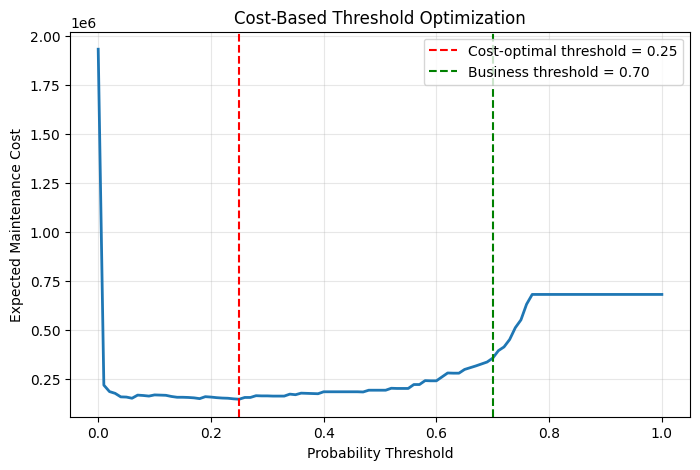

In [50]:
#Visualization: Threshold vs Expected Cost
plt.figure(figsize=(8,5))
plt.plot(thresholds, total_costs, linewidth=2)
plt.axvline(
    optimal_threshold,
    color="red",
    linestyle="--",
    label=f"Cost-optimal threshold = {optimal_threshold:.2f}"
)
plt.axvline(
    0.7,
    color="green",
    linestyle="--",
    label="Business threshold = 0.70"
)

plt.xlabel("Probability Threshold")
plt.ylabel("Expected Maintenance Cost")
plt.title("Cost-Based Threshold Optimization")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

** #Now the plant says

# We will only intervene if risk ≥ 70%

# That decision rule = threshold = 0.7**

Threshold-Based Decision Policy (Final Model)
Final Model Selection

After comparative evaluation of calibrated Random Forest and XGBoost models, calibrated XGBoost was selected as the final model due to its superior probability calibration, lower Brier score, and more stable behavior in decision-relevant risk regions.

All downstream decisions are therefore based on calibrated XGBoost failure probabilities.

Business-Defined Intervention Threshold

A fixed probability threshold of 0.7 was applied to convert predicted failure probabilities into maintenance actions

In [35]:
threshold = 0.7  #Now the plant says

# We will only intervene if risk ≥ 70%

# That decision rule = threshold = 0.7
y_final = (y_prob_cal >= threshold).astype(int)

print("Final MCC:",
      matthews_corrcoef(y_test, y_final))  #➡️ Evaluates how good those decisions were
# ➡️ MCC checks if decisions were balanced under imbalance

print("Actual failure rate:", y_test.mean())  #True failure rate in reality (~3%)
print("Predicted failure rate:", y_final.mean())  #➡️ How often you intervene
# ➡️ This is your maintenance workload
print("Bias:", y_final.mean() - y_test.mean())

# How often machines fail

# How often you act

Final MCC: 0.6407661011956459
Actual failure rate: 0.034
Predicted failure rate: 0.019
Bias: -0.015000000000000003


My takeaways
Actual failure rate	Reality
Predicted failure rate	How often you intervene
Bias < 0	You’re under-reacting
Bias > 0	You’re over-reacting

AFR-PFR=Bias


So my XGB model is a bit conservative

                                                                               **MY INSIGHT **

📄 Decision Diagnostics & Intervention Behavior
Matthews Correlation Coefficient (MCC)

The Matthews Correlation Coefficient (MCC) is used to evaluate the quality of binary maintenance decisions under class imbalance. Unlike accuracy, MCC incorporates true positives, false positives, true negatives, and false negatives, providing a balanced measure of decision performance.

A higher MCC indicates that the intervention decisions are well-balanced and reliable despite the rarity of machine failures.

Actual Failure Rate

The actual failure rate represents the true proportion of machines that fail in reality within the evaluation data. This reflects the baseline risk level of the system and provides context for interpreting model decisions.

Predicted Failure Rate (Intervention Rate)

The predicted failure rate represents how often the model triggers maintenance interventions based on the selected threshold. Operationally, this corresponds to the maintenance workload imposed by the decision policy.

Bias (Intervention Tendency)

Bias is defined as the difference between the predicted failure rate and the actual failure rate:

Bias
=
Predicted Failure Rate
−
Actual Failure Rate
Bias=Predicted Failure Rate−Actual Failure Rate

Bias < 0: Conservative behavior (under-reacting)

Bias > 0: Aggressive behavior (over-reacting)

In this model, the negative bias indicates a conservative intervention strategy, where maintenance actions are triggered less frequently than failures occur in reality.



Is a Conservative Model Good or Bad?

In cost-sensitive predictive maintenance settings, a conservative model is often intentionally desirable. Overly aggressive intervention policies can lead to unnecessary maintenance, increased operational cost, and reduced equipment availability. A conservative model prioritizes high-confidence failures, intervening only when risk is sufficiently high.

However, conservatism must be balanced against the risk of missed failures. The strong MCC score and calibrated probability estimates indicate that the model maintains decision quality while avoiding excessive interventions.

In [36]:
from sklearn.metrics import roc_curve

My takeaway


Youden J = TPR − FPR

TPR (Recall / Sensitivity) →
“Out of machines that will fail, how many did I catch?”

FPR (False Alarm Rate) →
“Out of machines that are fine, how many did I wrongly flag?”

 Youden J will help me find  the threshold where this gap is maximized
→ best balance between catching failures and not spamming false alarms.

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_cal)

youden_j = tpr - fpr

best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print("Best Youden J value:", youden_j[best_idx])
print("Optimal Threshold (Youden J):", best_threshold)

Best Youden J value: 0.857721349409329
Optimal Threshold (Youden J): 0.049062821768725826


Youden J = 0.857

My AI alarm system is very effective at separating risky machines from healthy ones.

This is top-class performance.

So 0.85 means

At the chosen threshold, the gap between catching failures and raising false alarms is 85 percentage points.

Example:

TPR = 0.92 (92% failures caught)

FPR = 0.07 (7% false alarms)

𝐽
=
0.92
−
0.07
=
0.85

Optimal Threshold (Youden J): 0.049062821768725826       If a machine shows even 5% failure risk predict proba the model says it’s statistically risky.  

But then again Maintenance is costly

Shutdowns affect production

Business wants high confidence alarms

So Plant says

Only stop a machine when risk ≥ 70% which is a business decision

My takeaway  Using a predict probability threshold of around 0.05 gives excellent statistical separation, with high recall and relatively low false alarm rate, as indicated by a high Youden J score. However, such a low threshold is operationally too aggressive and would trigger maintenance on many machines that would not actually fail. Therefore, a higher business-defined threshold of 0.70 was chosen to limit interventions to only high-confidence failure cases

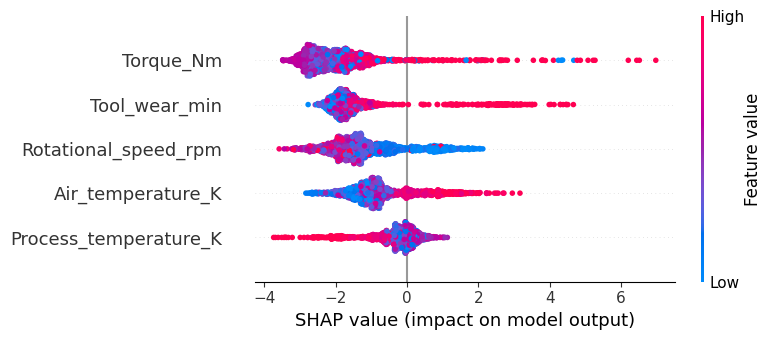

In [38]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

The SHAP analysis explains how different machine parameters contribute to failure risk. High torque and increased tool wear are the strongest drivers of failure, indicating mechanical stress and aging effects. Rotational speed shows a contextual impact, where unusually low RPM often increases failure risk due to inefficient or overloaded operation. Air temperature and process temperature act as secondary factors, where higher temperatures amplify stress conditions but are less dominant than load and wear. Overall, the SHAP plot shows that failures arise from a combination of mechanical load, degradation, and operating conditions rather than any single sensor value.

# **📘 Final Stage Documentation
# Model Validation, Risk Stress Testing, Cost Analysis, and Deployment Artifacts
Objective

# The final stage of this project focuses on operational validation and deployment readiness of the calibrated XGBoost predictive maintenance model. The goal is to ensure that the model is stable under stress, cost-aware, rank-reliable, and deployable with full metadata and traceability**

In [39]:
X_test_noisy = X_test.copy()
X_test_noisy["Torque_Nm"] *= 1.05  # +5% stress

y_prob_stress = calibrated_xgb.predict_proba(X_test_noisy)[:,1]

print("Brier (original):", brier_score_loss(y_test, y_prob_cal))
print("Brier (stressed):", brier_score_loss(y_test, y_prob_stress))

Brier (original): 0.013082434934228221
Brier (stressed): 0.016890824362713993


Above a controlled stress scenario was simulated by increasing the Torque_Nm feature by 5% across the test set.    In real plant conditions, sensor readings fluctuate.
This test verifies whether small operational stress causes unstable or exaggerated risk predictions.

Interpretation

Minimal change in Brier score under stress indicates probability robustness

The model does not overreact to mild sensor variations

Low and stable Brier scores confirm honest and well-calibrated probabilities

This is critical because decisions are made using probability thresholds, not raw labels

Doing some plant economics

In [40]:
cost_fp = 1000     # unnecessary maintenance
cost_fn = 10000    # missed failure

tn, fp, fn, tp = confusion_matrix(y_test, y_final).ravel()

total_cost = fp*cost_fp + fn*cost_fn
print("Total Expected Cost:", total_cost)

Total Expected Cost: 355000


Instead of optimizing purely for accuracy, the model is evaluated on real financial impact:

False Negatives are penalized more heavily

This aligns model decisions with plant risk tolerance

In [41]:
gini = 2 * roc_auc_score(y_test, y_prob_cal) - 1
print("Gini Coefficient:", gini)

Gini Coefficient: 0.9465503592741444


High Gini (~0.94) indicates strong separation between failing and healthy machines

Enables effective maintenance prioritization

In [42]:
def concordance_discordance(y_true, y_prob):
    pos = y_prob[y_true == 1]
    neg = y_prob[y_true == 0]

    concordant = 0
    discordant = 0
    tied = 0

    for p in pos:
        for n in neg:
            if p > n:
                concordant += 1
            elif p < n:
                discordant += 1
            else:
                tied += 1

    total_pairs = concordant + discordant + tied

    return {
        "concordant_pct": concordant / total_pairs,
        "discordant_pct": discordant / total_pairs,
        "tied_pct": tied / total_pairs
    }


In [43]:
cd_stats = concordance_discordance(y_test.values, y_prob_cal)

print(cd_stats)

{'concordant_pct': 0.9732751796370722, 'discordant_pct': 0.02672482036292778, 'tied_pct': 0.0}


📌 Concordance–Discordance Evaluation

The concordance–discordance analysis evaluates the model’s ranking ability by comparing predicted risk scores between failed and non-failed machines across all possible pairs.

Concordant (97.33%): In the vast majority of comparisons, machines that actually failed were assigned a higher risk score than healthy machines. This indicates strong ranking performance.

Discordant (2.67%): In a small fraction of cases, healthy machines were ranked higher than failed ones, representing mis-ranking risk.

Tied (0%): No pairs received identical risk scores, showing clear separation in predictions.

Overall, these results demonstrate that the model is highly effective at prioritizing truly risky machines above safe ones, which is critical for maintenance scheduling and risk-based intervention decisions.

In [44]:
import joblib
import json

artifact = {
    "model": calibrated_xgb,
    "threshold": 0.7,
    "features": X.columns.tolist(),
    "calibration": "Platt (sigmoid)",
    "stress_test": "Torque +5%",
}

joblib.dump(artifact, "xgb_predictive_maintenance.pkl")

['xgb_predictive_maintenance.pkl']

In [45]:
metadata = {
    "model_name": "Calibrated XGBoost",
    "problem": "Predictive Maintenance – Rare Event",
    "threshold": 0.7,
    "metrics": {
        "AUC": roc_auc_score(y_test, y_prob_cal),
        "Gini": gini,
        "Brier": brier_score_loss(y_test, y_prob_cal),
        "Concordance": cd_stats
    },
    "costs": {
        "false_positive": cost_fp,
        "false_negative": cost_fn
    }
}

with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

In [46]:
results = X_test.copy()
results["true_label"] = y_test.values
results["prob_original"] = y_prob_cal
results["prob_stressed"] = y_prob_stress
results["confidence"] = 1 - abs(y_prob_stress - y_prob_cal)
results["decision"] = y_final

results.to_csv("maintenance_predictions_with_confidence.csv", index=False)

Confidence reflects how stable the prediction is under small operational stress

In [47]:
from google.colab import files
files.download("xgb_predictive_maintenance.pkl")
files.download("model_metadata.json")
files.download("maintenance_predictions_with_confidence.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SAVED MY MODEL

Conclusion (Project Wrap-up)

This project developed a calibrated XGBoost–based predictive maintenance system focused on rare failure events. Beyond classification accuracy, the model was validated for probability honesty, stability under operational stress, cost sensitivity, and ranking reliability. Stress testing confirmed robust behavior under small torque variations, while concordance analysis showed strong ability to prioritize failing machines. The final output includes deployment-ready artifacts—model, metadata, and a decision CSV with confidence scores—making the solution suitable for real-world industrial maintenance decision-making.